<a href="https://colab.research.google.com/github/alcideschaux/PDL1_CD8_FOXP3_PENIS/blob/main/PDL1_CD8_FOXP3_PENIS_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

!pip install scikit-posthocs
import scikit_posthocs as sp

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
DF = pd.read_csv('PFCK_PRY_DF.csv')

In [3]:
DF.head()

,x,y,sp,tma,subtype,subtype_who,grade,pdl1_tumor,pdl1_tumor_location,pdl1_tumor_h,...,foxp3_lymph_intensity,foxp3_tumor,foxp3_tumor_intensity,cd8_tumor,cd8ki67_tumor,cd8_stroma,cd8ki67_stroma,ki67_tumor,cd8foxp3_tumor,cd8foxp3_stroma
0,1,3,S07-01439,852,Basaloid,HPV-associated,Grade 3,0.0,NaN,0.0,...,Strong staining,0.0,No staining,5.0,0.0,18.0,0.0,0.0,CD8 > FOXP3,CD8 > FOXP3
1,2,3,S07-01439,852,Basaloid,HPV-associated,NaN,NaN,NaN,NaN,...,Strong staining,0.0,No staining,NaN,NaN,22.0,0.0,0.0,NaN,CD8 <= FOXP3
2,3,3,S07-01439,852,Basaloid,HPV-associated,Grade 3,0.0,NaN,0.0,...,Strong staining,0.0,No staining,0.0,0.0,19.0,0.0,0.0,CD8 <= FOXP3,CD8 <= FOXP3
3,1,5,S04-05349,852,Basaloid,HPV-associated,Grade 3,0.0,NaN,0.0,...,Strong staining,0.0,No staining,0.0,0.0,12.0,0.0,90.0,CD8 <= FOXP3,CD8 <= FOXP3
4,2,5,S04-05349,852,Basaloid,HPV-associated,Grade 3,0.0,NaN,0.0,...,Strong staining,0.0,No staining,0.0,0.0,10.0,0.0,60.0,CD8 <= FOXP3,CD8 <= FOXP3


In [4]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   x                      528 non-null    int64  
 1   y                      528 non-null    int64  
 2   sp                     528 non-null    object 
 3   tma                    528 non-null    int64  
 4   subtype                528 non-null    object 
 5   subtype_who            528 non-null    object 
 6   grade                  504 non-null    object 
 7   pdl1_tumor             504 non-null    float64
 8   pdl1_tumor_location    331 non-null    object 
 9   pdl1_tumor_h           504 non-null    float64
 10  pdl1_lymph             497 non-null    float64
 11  host_response          504 non-null    object 
 12  foxp3_lymph_tumor      80 non-null     float64
 13  foxp3_lymph_stroma     80 non-null     float64
 14  foxp3_lymph_intensity  80 non-null     object 
 15  foxp3_

In [5]:
# Unique SP cases
DF['sp'].nunique()

108

In [6]:
def analyze_biomarker_by_group(dataframe, biomarker_col, group_col):
    """
    Performs Kruskal-Wallis and Dunn's post-hoc tests to compare a biomarker
    across different groups.

    Args:
        dataframe (pd.DataFrame): The input DataFrame.
        biomarker_col (str): The name of the column containing the biomarker data.
        group_col (str): The name of the column containing the group data.

    Prints:
        The Kruskal-Wallis H-statistic and p-value, and the Dunn's post-hoc test results.
    """
    print(f"## Statistical Comparison of {biomarker_col} by {group_col}\n")

    # Drop rows with missing values in the relevant columns
    df_clean = dataframe.dropna(subset=[biomarker_col, group_col]).copy()

    # Check if there are enough groups and data points
    if df_clean[group_col].nunique() < 2:
        print(f"Warning: Not enough unique groups ({df_clean[group_col].nunique()}) in '{group_col}' after dropping NaNs. Kruskal-Wallis requires at least two groups.")
        return
    if len(df_clean) < 2:
         print(f"Warning: Not enough data points ({len(df_clean)}) after dropping NaNs. Cannot perform statistical tests.")
         return

    # Create a list of biomarker values for each group
    # Use observed=True with groupby on categorical data to only include categories present after dropping NaNs
    groups = df_clean.groupby(group_col, observed=True)[biomarker_col].apply(list)

    # Perform Kruskal-Wallis test
    # Check if there are at least two non-empty groups to perform Kruskal-Wallis
    if len(groups) < 2:
        print(f"Warning: Less than two groups with data after dropping NaNs. Cannot perform Kruskal-Wallis test.")
        return

    # Ensure all groups passed to kruskal have at least one data point
    valid_groups = [g for g in groups if len(g) > 0]
    if len(valid_groups) < 2:
         print(f"Warning: Less than two groups with data points after dropping NaNs. Cannot perform Kruskal-Wallis test.")
         return


    try:
        h_statistic, p_value = stats.kruskal(*valid_groups)
        print(f"Kruskal-Wallis H-statistic: {h_statistic:.4f}")
        print(f"P-value: {p_value}")

        # Perform Dunn's test as a post-hoc test if Kruskal-Wallis is significant (optional, but common)
        # Or perform it always to see pairwise differences
        print(f"\nDunn's Post-hoc Test (Bonferroni Correction) for {biomarker_col} by {group_col}:")
        dunn_result = sp.posthoc_dunn(df_clean, val_col=biomarker_col, group_col=group_col, p_adjust='bonferroni')
        print(dunn_result) # Use display for better table formatting in notebooks

    except ValueError as e:
        print(f"An error occurred during statistical testing: {e}")
        print("This might happen if a group has only one data point after dropping NaNs.")

# Descriptive Analysis

## Pathologic features (spot by spot)

In [7]:
DF['subtype'].value_counts()

,count
subtype,
Usual,204
Warty-Basaloid,126
Warty,78
Basaloid,66
Papillary,42
Verrucous,9
Sarcomatoid,3


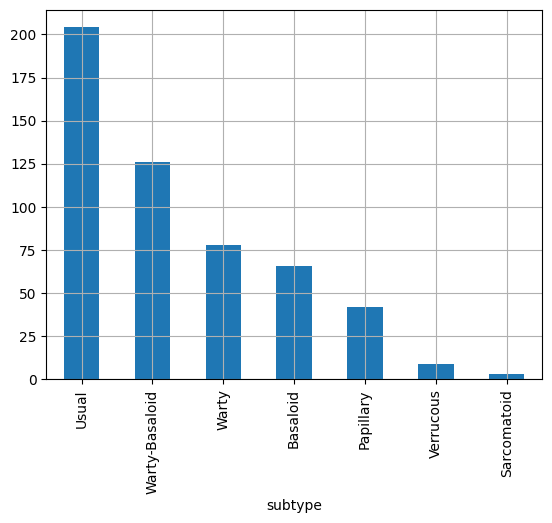

In [8]:
DF['subtype'].value_counts().plot(kind='bar')
plt.grid()
plt.show()

In [9]:
DF['subtype_who'].value_counts()

,count
subtype_who,
HPV-associated,270
HPV-independent,258


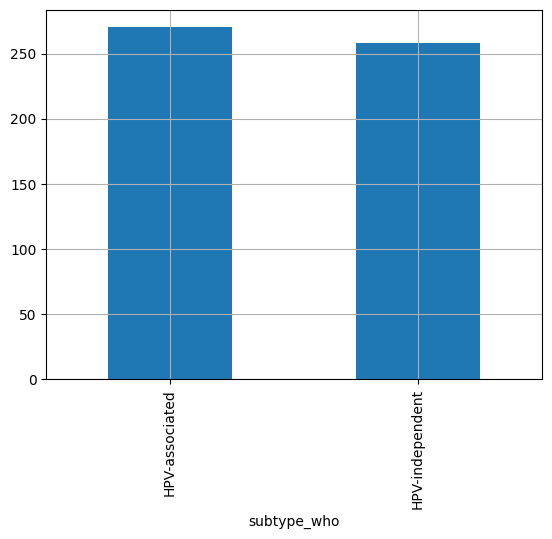

In [10]:
DF['subtype_who'].value_counts().plot(kind='bar')
plt.grid()
plt.show()

In [11]:
DF['grade'].value_counts()

,count
grade,
Grade 3,262
Grade 2,191
Grade 1,51


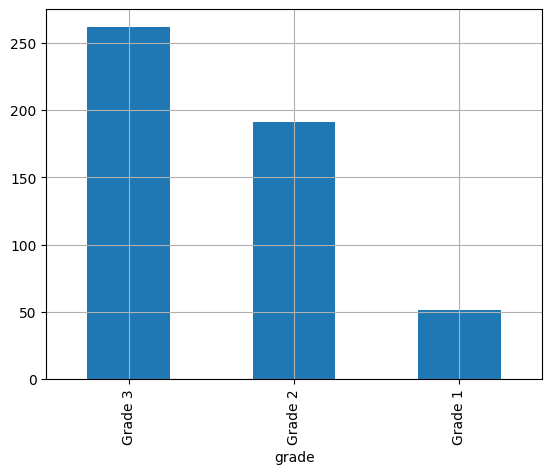

In [12]:
DF['grade'].value_counts().plot(kind='bar')
plt.grid()
plt.show()

## PD-L1 expression in tumor cells (%)

In [13]:
DF['pdl1_tumor'].describe()

,pdl1_tumor
count,504.000000
mean,25.583333
std,34.417865
min,0.000000
25%,0.000000
50%,5.000000
75%,40.000000
max,100.000000


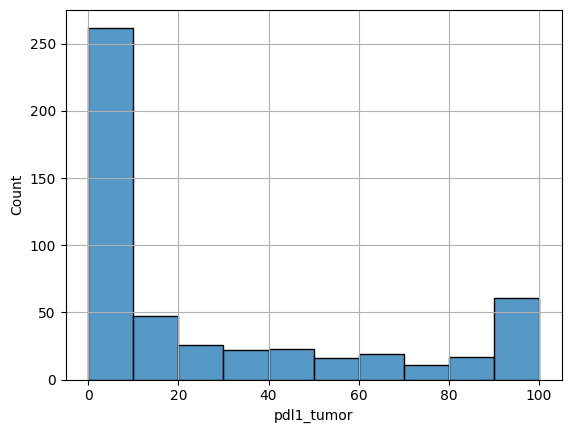

In [14]:
sns.histplot(DF['pdl1_tumor'], bins=10)
plt.grid(True)
plt.show()

In [15]:
DF['pdl1_tumor_location'].value_counts()

,count
pdl1_tumor_location,
Cytoplasmic/Membraneous,250
Cytplasmic,81


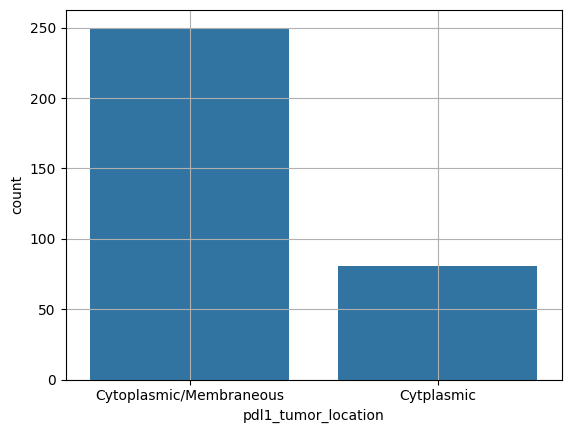

In [16]:
sns.countplot(data=DF, x='pdl1_tumor_location')
plt.grid()
plt.show()

In [17]:
# PD-L1 expression by subtypes
DF.groupby('subtype')['pdl1_tumor'].describe()

,count,mean,std,min,25%,50%,75%,max
subtype,,,,,,,,
Basaloid,64.0,31.734375,32.095711,0.0,0.0,25.0,50.0,100.0
Papillary,40.0,1.200000,3.603417,0.0,0.0,0.0,0.0,20.0
Sarcomatoid,3.0,100.000000,0.000000,100.0,100.0,100.0,100.0,100.0
Usual,192.0,25.302083,34.903943,0.0,0.0,5.0,50.0,100.0
Verrucous,7.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Warty,77.0,14.714286,22.810926,0.0,0.0,5.0,20.0,90.0
Warty-Basaloid,121.0,37.388430,39.246310,0.0,2.0,20.0,80.0,100.0


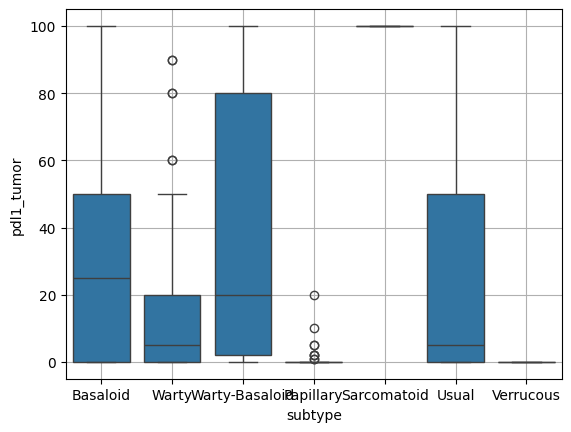

In [18]:
# prompt: #describe PD-L1 expression by histologic subtype

# Describe PD-L1 expression by histologic subtype
sns.boxplot(data=DF, x='subtype', y='pdl1_tumor')
plt.grid(True)
plt.show()

In [19]:
analyze_biomarker_by_group(DF, 'pdl1_tumor', 'subtype')

## Statistical Comparison of pdl1_tumor by subtype

Kruskal-Wallis H-statistic: 77.2567
P-value: 1.3157824502406166e-14

Dunn's Post-hoc Test (Bonferroni Correction) for pdl1_tumor by subtype:
                    Basaloid     Papillary  Sarcomatoid     Usual  Verrucous  \
Basaloid        1.000000e+00  6.089546e-08     0.450804  0.552173   0.007053   
Papillary       6.089546e-08  1.000000e+00     0.000413  0.000010   1.000000   
Sarcomatoid     4.508037e-01  4.132976e-04     1.000000  0.081948   0.001135   
Usual           5.521726e-01  9.775971e-06     0.081948  1.000000   0.084439   
Verrucous       7.053018e-03  1.000000e+00     0.001135  0.084439   1.000000   
Warty           2.229922e-01  1.840759e-03     0.049221  1.000000   0.245463   
Warty-Basaloid  1.000000e+00  1.102357e-11     0.715621  0.003089   0.001443   

                   Warty  Warty-Basaloid  
Basaloid        0.222992    1.000000e+00  
Papillary       0.001841    1.102357e-11  
Sarcomatoid     0.049221    7.156211e

## PD-L1 expression in lymphocytes (%)

In [20]:
DF['pdl1_lymph'].describe()

,pdl1_lymph
count,497.000000
mean,7.402414
std,10.400984
min,0.000000
25%,1.000000
50%,5.000000
75%,10.000000
max,70.000000


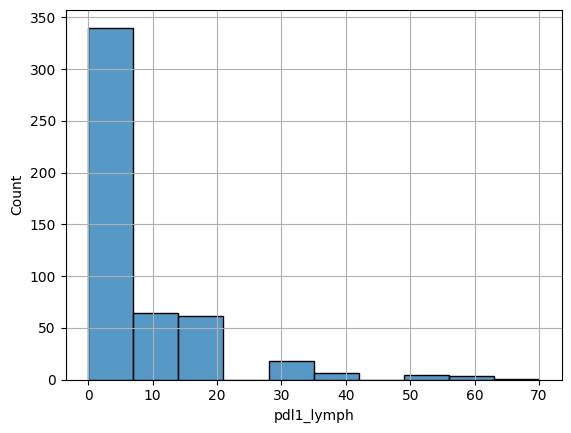

In [21]:
sns.histplot(DF['pdl1_lymph'], bins=10)
plt.grid(True)
plt.show()

## FOXP3 in intratumoral lymphocytes (HPF)

In [22]:
DF['foxp3_lymph_tumor'].describe()

,foxp3_lymph_tumor
count,80.000000
mean,10.350000
std,14.133272
min,0.000000
25%,1.000000
50%,4.000000
75%,12.250000
max,56.000000


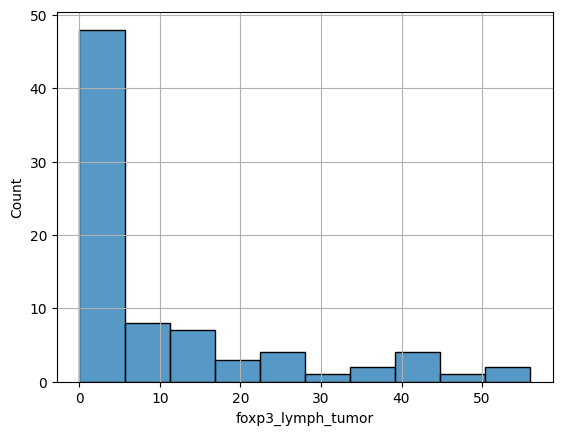

In [23]:
sns.histplot(DF['foxp3_lymph_tumor'], bins=10)
plt.grid(True)
plt.show()

## FOXP3 in peritumoral lymphocytes (HPF)

In [24]:
DF['foxp3_lymph_stroma'].describe()

,foxp3_lymph_stroma
count,80.000000
mean,46.800000
std,38.227302
min,0.000000
25%,15.000000
50%,38.000000
75%,71.250000
max,145.000000


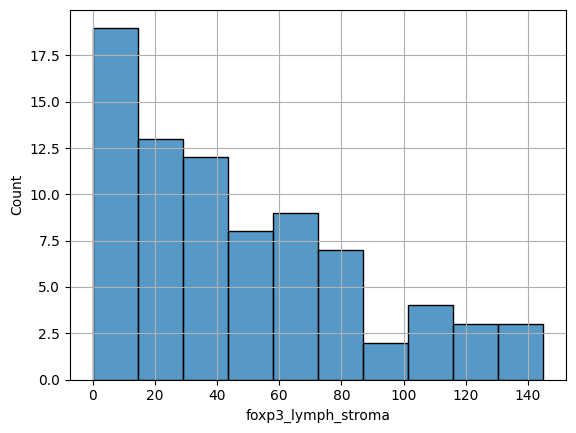

In [25]:
sns.histplot(DF['foxp3_lymph_stroma'], bins=10)
plt.grid(True)
plt.show()

## CD8 in intratumoral lymphocytes (HPF)

In [26]:
DF['cd8_tumor'].describe()

,cd8_tumor
count,506.000000
mean,10.031621
std,15.505827
min,0.000000
25%,0.000000
50%,4.000000
75%,12.000000
max,120.000000


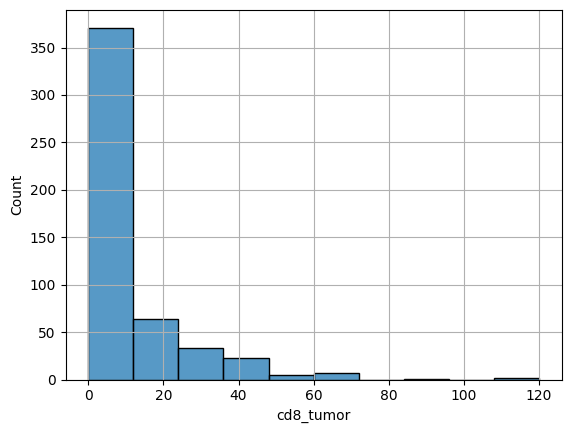

In [27]:
sns.histplot(DF['cd8_tumor'], bins=10)
plt.grid(True)
plt.show()

## CD8 in peritumoral lymphocytes (HPF)

In [28]:
DF['cd8_stroma'].describe()

,cd8_stroma
count,503.000000
mean,26.556660
std,26.596368
min,0.000000
25%,5.000000
50%,19.000000
75%,40.000000
max,150.000000


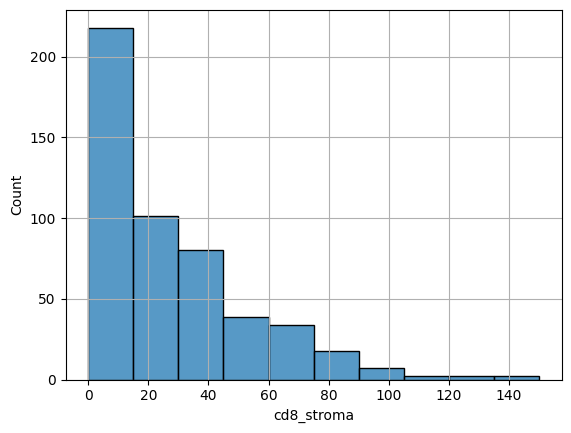

In [29]:
sns.histplot(DF['cd8_stroma'], bins=10)
plt.grid(True)
plt.show()

# Biomarkers by subtype

## PD-L1 in tumor cells

In [30]:
DF.groupby('subtype_who', observed=True)['pdl1_tumor'].describe()

,count,mean,std,min,25%,50%,75%,max
subtype_who,,,,,,,,
HPV-associated,262.0,29.343511,34.682638,0.0,1.0,10.0,50.0,100.0
HPV-independent,242.0,21.512397,33.729487,0.0,0.0,1.0,30.0,100.0


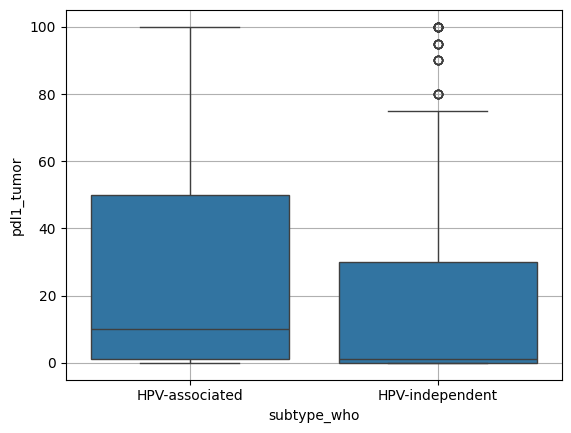

In [31]:
sns.boxplot(data=DF, x='subtype_who', y='pdl1_tumor')
plt.grid(True)

In [32]:
analyze_biomarker_by_group(DF, 'pdl1_tumor', 'subtype_who')

## Statistical Comparison of pdl1_tumor by subtype_who

Kruskal-Wallis H-statistic: 20.6395
P-value: 5.544014189693285e-06

Dunn's Post-hoc Test (Bonferroni Correction) for pdl1_tumor by subtype_who:
                 HPV-associated  HPV-independent
HPV-associated         1.000000         0.000006
HPV-independent        0.000006         1.000000


## PD-L1 in lymphocytes

In [33]:
DF.groupby('subtype_who', observed=True)['pdl1_lymph'].describe()

,count,mean,std,min,25%,50%,75%,max
subtype_who,,,,,,,,
HPV-associated,258.0,7.096899,9.556422,0.0,1.0,5.0,10.0,60.0
HPV-independent,239.0,7.732218,11.252798,0.0,1.0,2.0,10.0,70.0


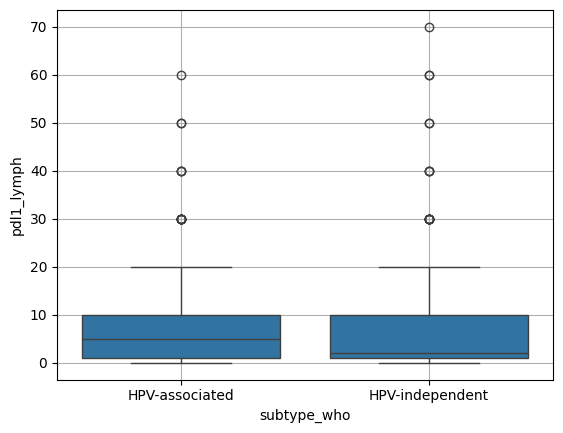

In [34]:
sns.boxplot(data=DF, x='subtype_who', y='pdl1_lymph')
plt.grid(True)

In [35]:
analyze_biomarker_by_group(DF, 'pdl1_lymph', 'subtype_who')

## Statistical Comparison of pdl1_lymph by subtype_who

Kruskal-Wallis H-statistic: 0.0004
P-value: 0.9845795631001683

Dunn's Post-hoc Test (Bonferroni Correction) for pdl1_lymph by subtype_who:
                 HPV-associated  HPV-independent
HPV-associated          1.00000          0.98458
HPV-independent         0.98458          1.00000


## FOXP3 in intratumoral lymphocytes

In [36]:
DF.groupby('subtype_who', observed=True)['foxp3_lymph_tumor'].describe()

,count,mean,std,min,25%,50%,75%,max
subtype_who,,,,,,,,
HPV-associated,42.0,7.880952,13.819750,0.0,0.00,2.0,5.75,56.0
HPV-independent,38.0,13.078947,14.152417,0.0,2.25,6.5,17.50,47.0


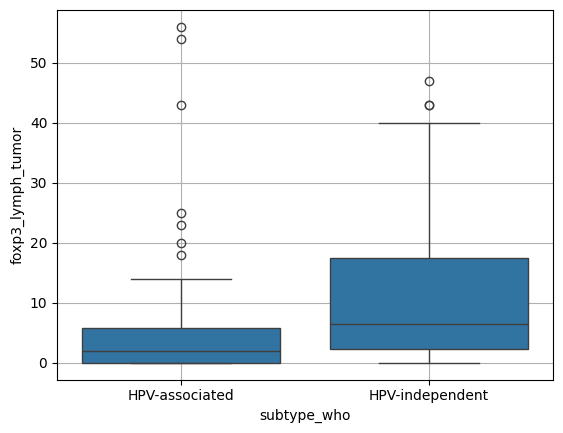

In [37]:
sns.boxplot(data=DF, x='subtype_who', y='foxp3_lymph_tumor')
plt.grid(True)

In [38]:
analyze_biomarker_by_group(DF, 'foxp3_lymph_tumor', 'subtype_who')

## Statistical Comparison of foxp3_lymph_tumor by subtype_who

Kruskal-Wallis H-statistic: 9.4419
P-value: 0.002120891497066086

Dunn's Post-hoc Test (Bonferroni Correction) for foxp3_lymph_tumor by subtype_who:
                 HPV-associated  HPV-independent
HPV-associated         1.000000         0.002121
HPV-independent        0.002121         1.000000


## FOXP3 in peritumoral lymphocytes

In [39]:
DF.groupby('subtype_who', observed=True)['foxp3_lymph_stroma'].describe()

,count,mean,std,min,25%,50%,75%,max
subtype_who,,,,,,,,
HPV-associated,42.0,33.976190,36.357633,0.0,8.00,22.5,47.50,133.0
HPV-independent,38.0,60.973684,35.529574,13.0,33.25,57.5,76.25,145.0


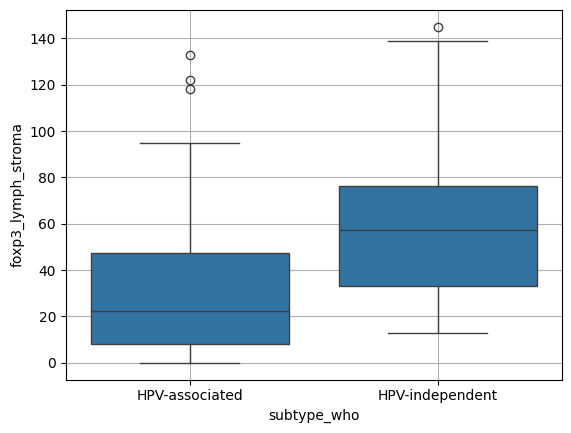

In [40]:
sns.boxplot(data=DF, x='subtype_who', y='foxp3_lymph_stroma')
plt.grid(True)

In [41]:
analyze_biomarker_by_group(DF, 'foxp3_lymph_stroma', 'subtype_who')

## Statistical Comparison of foxp3_lymph_stroma by subtype_who

Kruskal-Wallis H-statistic: 13.8049
P-value: 0.0002028078455710558

Dunn's Post-hoc Test (Bonferroni Correction) for foxp3_lymph_stroma by subtype_who:
                 HPV-associated  HPV-independent
HPV-associated         1.000000         0.000203
HPV-independent        0.000203         1.000000


## CD8 in intratumoral lymphocytes

In [42]:
DF.groupby('subtype_who', observed=True)['cd8_tumor'].describe()

,count,mean,std,min,25%,50%,75%,max
subtype_who,,,,,,,,
HPV-associated,257.0,9.225681,13.546637,0.0,0.0,4.0,11.0,65.0
HPV-independent,249.0,10.863454,17.285477,0.0,0.0,5.0,13.0,120.0


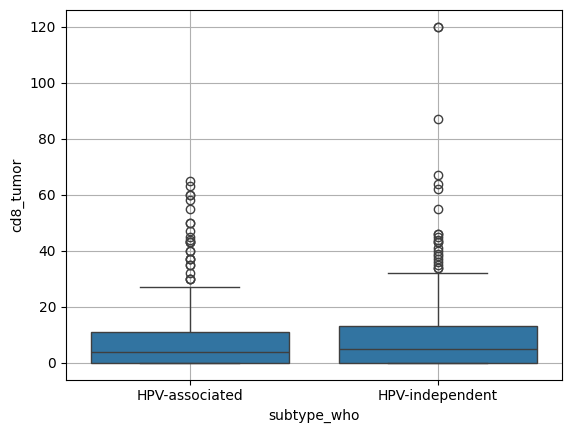

In [43]:
sns.boxplot(data=DF, x='subtype_who', y='cd8_tumor')
plt.grid(True)

In [44]:
analyze_biomarker_by_group(DF, 'cd8_tumor', 'subtype_who')

## Statistical Comparison of cd8_tumor by subtype_who

Kruskal-Wallis H-statistic: 0.0043
P-value: 0.9479244120152166

Dunn's Post-hoc Test (Bonferroni Correction) for cd8_tumor by subtype_who:
                 HPV-associated  HPV-independent
HPV-associated         1.000000         0.947924
HPV-independent        0.947924         1.000000


## CD8 in peritumoral lymphocytes

In [45]:
DF.groupby('subtype_who', observed=True)['cd8_stroma'].describe()

,count,mean,std,min,25%,50%,75%,max
subtype_who,,,,,,,,
HPV-associated,253.0,24.87747,24.596845,0.0,4.0,18.0,40.00,116.0
HPV-independent,250.0,28.25600,28.426020,0.0,7.0,22.0,41.75,150.0


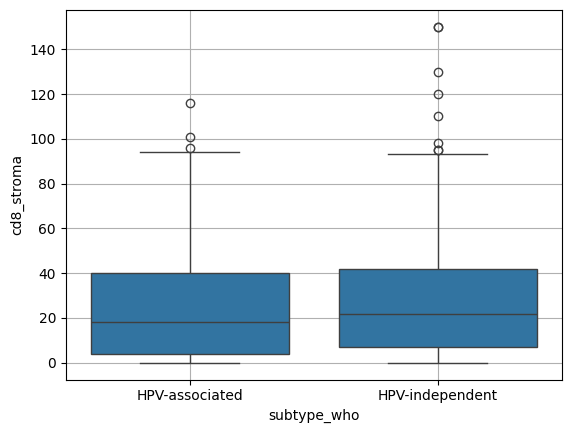

In [46]:
sns.boxplot(data=DF, x='subtype_who', y='cd8_stroma')
plt.grid(True)

In [47]:
analyze_biomarker_by_group(DF, 'cd8_stroma', 'subtype_who')

## Statistical Comparison of cd8_stroma by subtype_who

Kruskal-Wallis H-statistic: 1.3741
P-value: 0.24111545015473634

Dunn's Post-hoc Test (Bonferroni Correction) for cd8_stroma by subtype_who:
                 HPV-associated  HPV-independent
HPV-associated         1.000000         0.241115
HPV-independent        0.241115         1.000000


# Biomarkers by grade

## PD-L1 in tumor cells

In [48]:
DF.groupby('grade', observed=True)['pdl1_tumor'].describe()

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,51.0,7.882353,20.689753,0.0,0.0,0.0,5.0,90.0
Grade 2,189.0,21.084656,33.604604,0.0,0.0,1.0,30.0,100.0
Grade 3,258.0,32.275194,35.663116,0.0,1.0,15.0,60.0,100.0


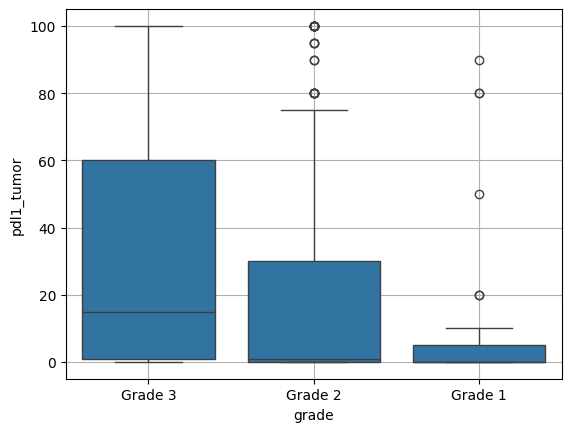

In [49]:
sns.boxplot(data=DF, x='grade', y='pdl1_tumor')
plt.grid(True)

In [50]:
analyze_biomarker_by_group(DF, 'pdl1_tumor', 'grade')

## Statistical Comparison of pdl1_tumor by grade

Kruskal-Wallis H-statistic: 45.0078
P-value: 1.685295938205074e-10

Dunn's Post-hoc Test (Bonferroni Correction) for pdl1_tumor by grade:
              Grade 1   Grade 2       Grade 3
Grade 1  1.000000e+00  0.029541  3.255197e-08
Grade 2  2.954131e-02  1.000000  2.930582e-06
Grade 3  3.255197e-08  0.000003  1.000000e+00


## PD-L1 in lymphocytes

In [51]:
DF.groupby('grade', observed=True)['pdl1_lymph'].describe()

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,48.0,8.729167,13.603409,0.0,0.75,2.0,6.25,60.0
Grade 2,187.0,5.930481,8.777444,0.0,0.00,2.0,7.50,60.0
Grade 3,256.0,8.277344,10.780394,0.0,1.00,5.0,10.00,70.0


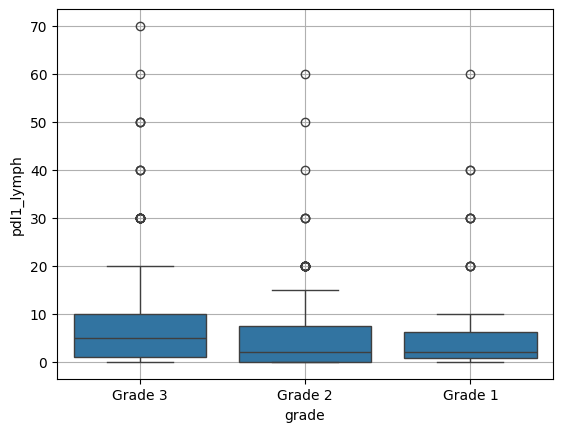

In [52]:
sns.boxplot(data=DF, x='grade', y='pdl1_lymph')
plt.grid(True)

In [53]:
analyze_biomarker_by_group(DF, 'pdl1_lymph', 'grade')

## Statistical Comparison of pdl1_lymph by grade

Kruskal-Wallis H-statistic: 8.5722
P-value: 0.013758366427775618

Dunn's Post-hoc Test (Bonferroni Correction) for pdl1_lymph by grade:
          Grade 1  Grade 2   Grade 3
Grade 1  1.000000  1.00000  0.653614
Grade 2  1.000000  1.00000  0.011780
Grade 3  0.653614  0.01178  1.000000


## FOXP3 in intratumoral lymphocytes

In [54]:
DF.groupby('grade', observed=True)['foxp3_lymph_tumor'].describe()

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,7.0,15.571429,14.570028,2.0,5.0,6.0,26.0,39.0
Grade 2,29.0,7.172414,10.488323,0.0,2.0,3.0,7.0,43.0
Grade 3,43.0,11.790698,16.045409,0.0,1.0,4.0,15.0,56.0


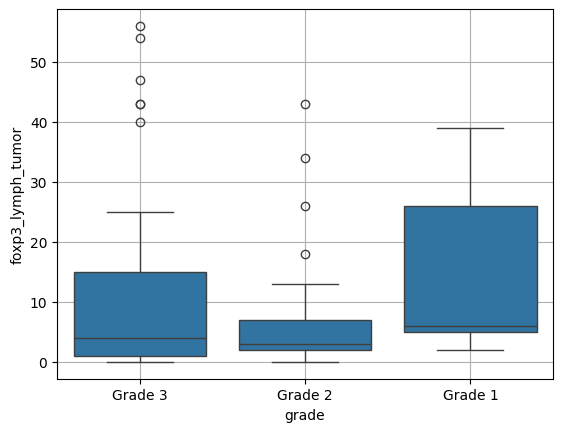

In [55]:
sns.boxplot(data=DF, x='grade', y='foxp3_lymph_tumor')
plt.grid(True)

In [56]:
analyze_biomarker_by_group(DF, 'foxp3_lymph_tumor', 'grade')

## Statistical Comparison of foxp3_lymph_tumor by grade

Kruskal-Wallis H-statistic: 2.9371
P-value: 0.23025627567082219

Dunn's Post-hoc Test (Bonferroni Correction) for foxp3_lymph_tumor by grade:
          Grade 1   Grade 2   Grade 3
Grade 1  1.000000  0.261783  0.411564
Grade 2  0.261783  1.000000  1.000000
Grade 3  0.411564  1.000000  1.000000


## FOXP3 in peritumoral lymphocytes

In [57]:
DF.groupby('grade', observed=True)['foxp3_lymph_stroma'].describe()

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,7.0,58.142857,38.881995,15.0,24.0,57.0,90.5,106.0
Grade 2,29.0,54.724138,32.702006,0.0,27.0,57.0,71.0,125.0
Grade 3,43.0,39.813953,41.269299,0.0,8.0,25.0,63.5,145.0


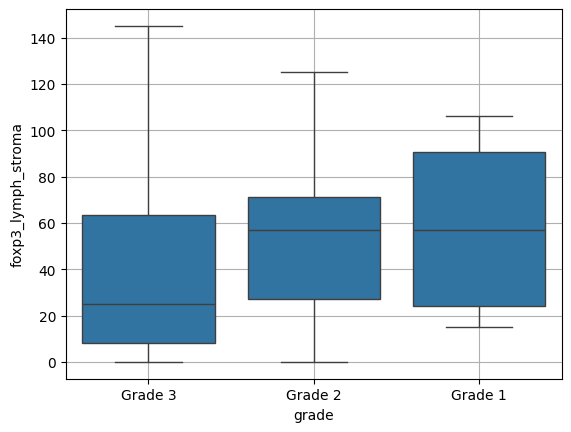

In [58]:
sns.boxplot(data=DF, x='grade', y='foxp3_lymph_stroma')
plt.grid(True)

In [59]:
analyze_biomarker_by_group(DF, 'foxp3_lymph_stroma', 'grade')

## Statistical Comparison of foxp3_lymph_stroma by grade

Kruskal-Wallis H-statistic: 5.8109
P-value: 0.054722840710112214

Dunn's Post-hoc Test (Bonferroni Correction) for foxp3_lymph_stroma by grade:
          Grade 1   Grade 2   Grade 3
Grade 1  1.000000  1.000000  0.455408
Grade 2  1.000000  1.000000  0.078614
Grade 3  0.455408  0.078614  1.000000


## CD8 in intratumoral lymphocytes

In [60]:
DF.groupby('grade', observed=True)['cd8_tumor'].describe()

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,50.0,6.160000,10.106292,0.0,0.0,1.0,8.75,46.0
Grade 2,188.0,7.531915,11.664840,0.0,0.0,2.0,10.00,58.0
Grade 3,256.0,12.761719,18.379492,0.0,1.0,6.0,15.00,120.0


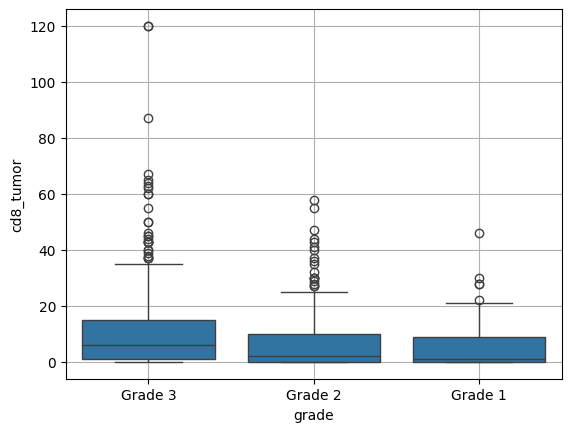

In [61]:
sns.boxplot(data=DF, x='grade', y='cd8_tumor')
plt.grid(True)

In [62]:
analyze_biomarker_by_group(DF, 'cd8_tumor', 'grade')

## Statistical Comparison of cd8_tumor by grade

Kruskal-Wallis H-statistic: 23.1739
P-value: 9.286627735563502e-06

Dunn's Post-hoc Test (Bonferroni Correction) for cd8_tumor by grade:
         Grade 1   Grade 2   Grade 3
Grade 1  1.00000  1.000000  0.003240
Grade 2  1.00000  1.000000  0.000059
Grade 3  0.00324  0.000059  1.000000


## CD8 in peritumoral lymphocytes

In [63]:
DF.groupby('grade', observed=True)['cd8_stroma'].describe()

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
Grade 1,50.0,26.340000,23.402956,0.0,6.75,24.5,39.5,95.0
Grade 2,190.0,27.852632,30.178120,0.0,4.00,16.0,44.0,150.0
Grade 3,245.0,25.367347,24.401772,0.0,5.00,19.0,40.0,150.0


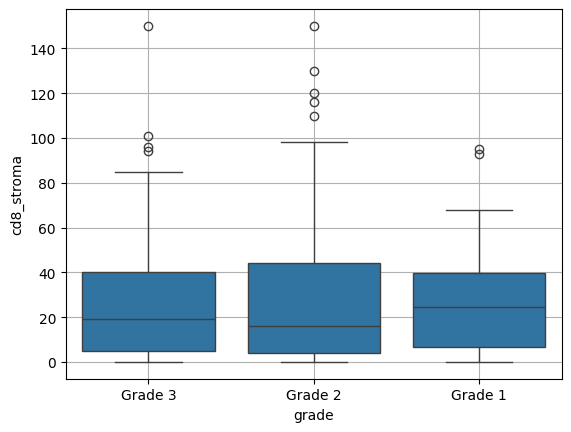

In [64]:
sns.boxplot(data=DF, x='grade', y='cd8_stroma')
plt.grid(True)

In [65]:
analyze_biomarker_by_group(DF, 'cd8_stroma', 'grade')

## Statistical Comparison of cd8_stroma by grade

Kruskal-Wallis H-statistic: 0.1703
P-value: 0.9183923903214879

Dunn's Post-hoc Test (Bonferroni Correction) for cd8_stroma by grade:
         Grade 1  Grade 2  Grade 3
Grade 1      1.0      1.0      1.0
Grade 2      1.0      1.0      1.0
Grade 3      1.0      1.0      1.0


# Correlation matrix PD-L1/FOXP3/CD8

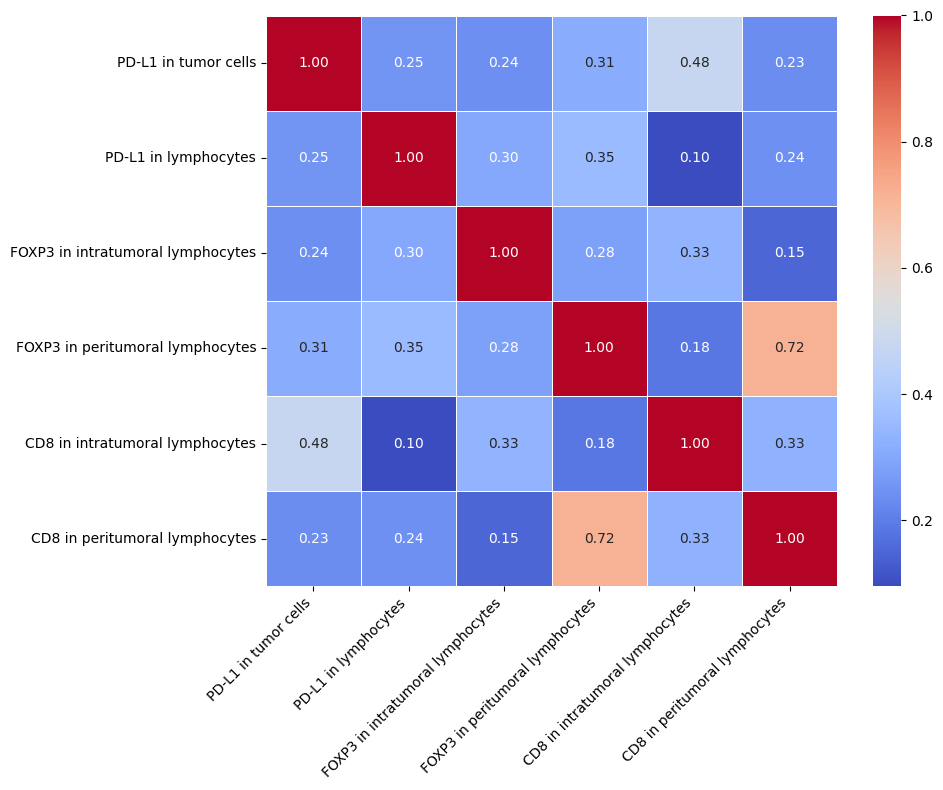

In [66]:
# Correlation matrix pdl1_tumor pdl1_lymph foxp3_lymph_tumor foxp3_lymph_stroma cd8_tumor cd8_stroma

selected_columns = ['pdl1_tumor', 'pdl1_lymph', 'foxp3_lymph_tumor', 'foxp3_lymph_stroma', 'cd8_tumor', 'cd8_stroma']
correlation_matrix = DF[selected_columns].corr()

# Define the new labels based on the correspondence
new_labels = {
    'pdl1_tumor': 'PD-L1 in tumor cells',
    'pdl1_lymph': 'PD-L1 in lymphocytes',
    'foxp3_lymph_tumor': 'FOXP3 in intratumoral lymphocytes',
    'foxp3_lymph_stroma': 'FOXP3 in peritumoral lymphocytes',
    'cd8_tumor': 'CD8 in intratumoral lymphocytes',
    'cd8_stroma': 'CD8 in peritumoral lymphocytes'
}

# Rename the columns and index of the correlation matrix using the new labels
correlation_matrix_labeled = correlation_matrix.rename(columns=new_labels, index=new_labels)

plt.figure(figsize=(10, 8)) # Adjusted figure size for longer labels
sns.heatmap(correlation_matrix_labeled, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.yticks(rotation=0) # Keep y-axis labels horizontal
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [67]:
# Load dataset (assuming DF is already loaded as in the original notebook)
# DF = pd.read_csv('PFCK_PRY_DF.csv')

selected_columns_for_spearman = ['pdl1_tumor', 'pdl1_lymph', 'foxp3_lymph_tumor', 'foxp3_lymph_stroma', 'cd8_tumor', 'cd8_stroma']

# Calculate Spearman correlation matrix (pandas handles NaNs appropriately)
spearman_corr = DF[selected_columns_for_spearman].corr(method='spearman')

# Calculate p-values for each pair of variables
p_values = pd.DataFrame(np.nan, index=selected_columns_for_spearman, columns=selected_columns_for_spearman)

for col1 in selected_columns_for_spearman:
  for col2 in selected_columns_for_spearman:
    # For the diagonal (correlation of a variable with itself), p-value is not meaningful.
    # Set it to 0 or NaN, 0 is common for correlation matrices with p-values
    if col1 == col2:
        p_values.loc[col1, col2] = 0.0
    else:
        # Drop rows with NaN in either column for this specific pair
        temp_df = DF[[col1, col2]].dropna()
        if len(temp_df) >= 2: # Need at least two data points to calculate correlation and p-value
            # stats.spearmanr returns a SignificanceResult object
            # result.pvalue should typically be a scalar for two 1D inputs
            result = stats.spearmanr(temp_df[col1], temp_df[col2])

            # Access the p-value attribute
            # While it *should* be a scalar, the error suggests it might be an array
            # Access the scalar value robustly
            if isinstance(result.pvalue, (np.ndarray, list)):
                # If it's an array/list, try to extract the first element
                # This handles cases where it might return a 1-element array
                try:
                    p_val = result.pvalue.flatten()[0]
                except IndexError:
                    # Handle unexpected empty array case, though unlikely here
                    p_val = np.nan
            else:
                # If it's already a scalar, use it directly
                p_val = result.pvalue

            p_values.loc[col1, col2] = p_val
        else:
            # Not enough data after dropping NaNs
            p_values.loc[col1, col2] = np.nan

print("\nSpearman Correlation Matrix:")
print(spearman_corr)

print("\nP-values for Spearman Correlation:")
print(p_values) # Using display for better formatting in notebooks


Spearman Correlation Matrix:
                    pdl1_tumor  pdl1_lymph  foxp3_lymph_tumor  \
pdl1_tumor            1.000000    0.474883           0.292566   
pdl1_lymph            0.474883    1.000000           0.415997   
foxp3_lymph_tumor     0.292566    0.415997           1.000000   
foxp3_lymph_stroma    0.332630    0.514857           0.417969   
cd8_tumor             0.408063    0.268081           0.489072   
cd8_stroma            0.251297    0.430892           0.281465   

                    foxp3_lymph_stroma  cd8_tumor  cd8_stroma  
pdl1_tumor                    0.332630   0.408063    0.251297  
pdl1_lymph                    0.514857   0.268081    0.430892  
foxp3_lymph_tumor             0.417969   0.489072    0.281465  
foxp3_lymph_stroma            1.000000   0.235284    0.753114  
cd8_tumor                     0.235284   1.000000    0.369526  
cd8_stroma                    0.753114   0.369526    1.000000  

P-values for Spearman Correlation:
                      pdl1_tum

# Host Response

In [68]:
categories = ['No inflammatory cells', 'Rare inflammatory cells', 'Lymphoid aggregates', 'Intense inflammation']
DF['host_response'] = pd.Categorical(DF['host_response'], categories=categories, ordered=True)

In [69]:
DF['host_response'].value_counts(sort=False)

,count
host_response,
No inflammatory cells,4
Rare inflammatory cells,96
Lymphoid aggregates,154
Intense inflammation,250


## FOXP3 in intratumoral lymphocytes

In [70]:
DF.groupby('host_response', observed=True)['foxp3_lymph_tumor'].describe()

,count,mean,std,min,25%,50%,75%,max
host_response,,,,,,,,
No inflammatory cells,1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0
Rare inflammatory cells,23.0,5.521739,9.089802,0.0,1.0,3.0,6.5,43.0
Lymphoid aggregates,31.0,12.000000,15.567059,0.0,1.5,4.0,15.5,54.0
Intense inflammation,23.0,13.826087,16.033069,0.0,2.0,6.0,21.5,56.0


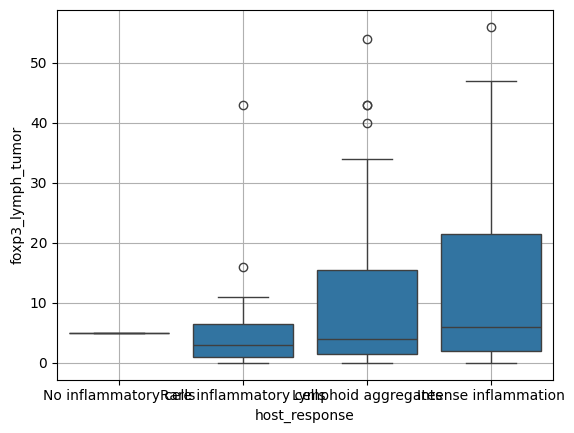

In [71]:
sns.boxplot(data=DF, x='host_response', y='foxp3_lymph_tumor')
plt.grid(True)

In [72]:
analyze_biomarker_by_group(DF, 'foxp3_lymph_tumor', 'host_response')

## Statistical Comparison of foxp3_lymph_tumor by host_response

Kruskal-Wallis H-statistic: 3.2785
P-value: 0.3506419078552601

Dunn's Post-hoc Test (Bonferroni Correction) for foxp3_lymph_tumor by host_response:
                         No inflammatory cells  Rare inflammatory cells  \
No inflammatory cells                      1.0                 1.000000   
Rare inflammatory cells                    1.0                 1.000000   
Lymphoid aggregates                        1.0                 1.000000   
Intense inflammation                       1.0                 0.472492   

                         Lymphoid aggregates  Intense inflammation  
No inflammatory cells                    1.0              1.000000  
Rare inflammatory cells                  1.0              0.472492  
Lymphoid aggregates                      1.0              1.000000  
Intense inflammation                     1.0              1.000000  


## FOXP3 in peritumoral lymphocytes

In [73]:
DF.groupby('host_response', observed=True)['foxp3_lymph_stroma'].describe()

,count,mean,std,min,25%,50%,75%,max
host_response,,,,,,,,
No inflammatory cells,1.0,29.000000,NaN,29.0,29.0,29.0,29.0,29.0
Rare inflammatory cells,23.0,21.130435,18.447233,0.0,6.0,16.0,35.5,57.0
Lymphoid aggregates,31.0,34.580645,28.075819,0.0,14.0,32.0,53.5,110.0
Intense inflammation,23.0,88.000000,32.170003,27.0,65.0,80.0,112.0,145.0


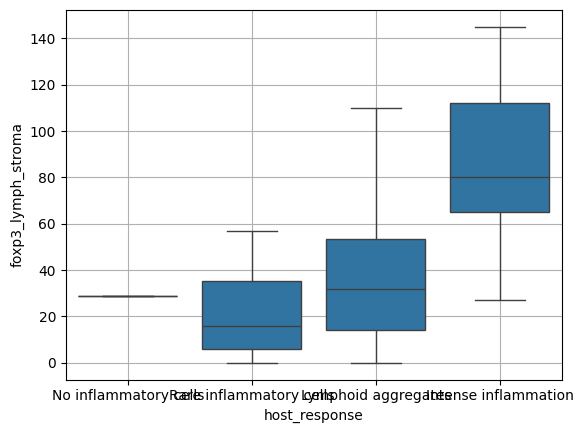

In [74]:
sns.boxplot(data=DF, x='host_response', y='foxp3_lymph_stroma')
plt.grid(True)

In [75]:
analyze_biomarker_by_group(DF, 'foxp3_lymph_stroma', 'host_response')

## Statistical Comparison of foxp3_lymph_stroma by host_response

Kruskal-Wallis H-statistic: 37.6436
P-value: 3.3627096451552104e-08

Dunn's Post-hoc Test (Bonferroni Correction) for foxp3_lymph_stroma by host_response:
                         No inflammatory cells  Rare inflammatory cells  \
No inflammatory cells                      1.0             1.000000e+00   
Rare inflammatory cells                    1.0             1.000000e+00   
Lymphoid aggregates                        1.0             7.050320e-01   
Intense inflammation                       1.0             3.097523e-08   

                         Lymphoid aggregates  Intense inflammation  
No inflammatory cells               1.000000          1.000000e+00  
Rare inflammatory cells             0.705032          3.097523e-08  
Lymphoid aggregates                 1.000000          1.605085e-05  
Intense inflammation                0.000016          1.000000e+00  


## CD8 in intratumoral lymphocytes

In [76]:
DF.groupby('host_response', observed=True)['cd8_tumor'].describe()

,count,mean,std,min,25%,50%,75%,max
host_response,,,,,,,,
No inflammatory cells,3.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Rare inflammatory cells,96.0,4.677083,8.573515,0.0,0.0,1.5,5.0,46.0
Lymphoid aggregates,151.0,7.331126,11.835946,0.0,0.0,2.0,10.0,62.0
Intense inflammation,243.0,14.082305,18.659670,0.0,1.0,8.0,20.0,120.0


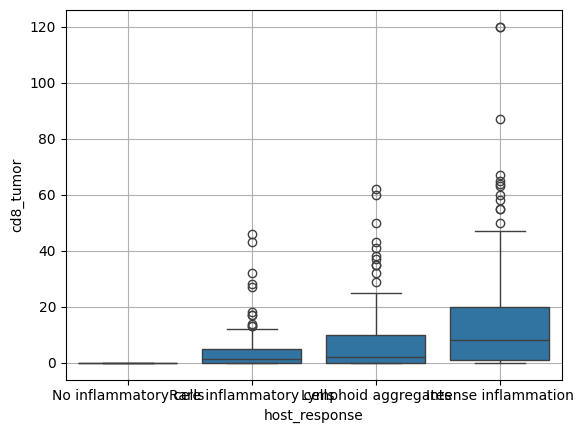

In [77]:
sns.boxplot(data=DF, x='host_response', y='cd8_tumor')
plt.grid(True)

In [78]:
analyze_biomarker_by_group(DF, 'cd8_tumor', 'host_response')

## Statistical Comparison of cd8_tumor by host_response

Kruskal-Wallis H-statistic: 46.5498
P-value: 4.3328936521493386e-10

Dunn's Post-hoc Test (Bonferroni Correction) for cd8_tumor by host_response:
                         No inflammatory cells  Rare inflammatory cells  \
No inflammatory cells                 1.000000             1.000000e+00   
Rare inflammatory cells               1.000000             1.000000e+00   
Lymphoid aggregates                   0.629984             8.527746e-01   
Intense inflammation                  0.077144             5.797112e-08   

                         Lymphoid aggregates  Intense inflammation  
No inflammatory cells               0.629984          7.714379e-02  
Rare inflammatory cells             0.852775          5.797112e-08  
Lymphoid aggregates                 1.000000          8.425050e-06  
Intense inflammation                0.000008          1.000000e+00  


## CD8 in peritumoral lymphocytes

In [79]:
DF.groupby('host_response', observed=True)['cd8_stroma'].describe()

,count,mean,std,min,25%,50%,75%,max
host_response,,,,,,,,
No inflammatory cells,3.0,6.333333,10.969655,0.0,0.0,0.0,9.50,19.0
Rare inflammatory cells,88.0,9.045455,13.126186,0.0,0.0,4.0,12.50,64.0
Lymphoid aggregates,152.0,18.618421,19.872086,0.0,4.0,12.0,27.25,93.0
Intense inflammation,242.0,37.826446,28.767252,0.0,15.0,32.5,55.75,150.0


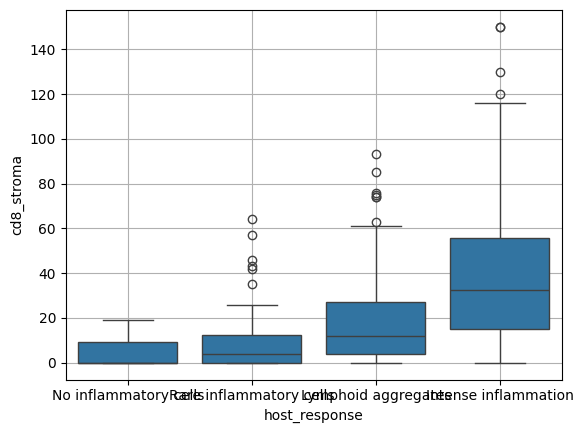

In [80]:
sns.boxplot(data=DF, x='host_response', y='cd8_stroma')
plt.grid(True)

In [81]:
analyze_biomarker_by_group(DF, 'cd8_stroma', 'host_response')

## Statistical Comparison of cd8_stroma by host_response

Kruskal-Wallis H-statistic: 115.4811
P-value: 7.2528345824633715e-25

Dunn's Post-hoc Test (Bonferroni Correction) for cd8_stroma by host_response:
                         No inflammatory cells  Rare inflammatory cells  \
No inflammatory cells                 1.000000             1.000000e+00   
Rare inflammatory cells               1.000000             1.000000e+00   
Lymphoid aggregates                   1.000000             1.310882e-03   
Intense inflammation                  0.093687             6.446119e-22   

                         Lymphoid aggregates  Intense inflammation  
No inflammatory cells           1.000000e+00          9.368729e-02  
Rare inflammatory cells         1.310882e-03          6.446119e-22  
Lymphoid aggregates             1.000000e+00          1.444389e-11  
Intense inflammation            1.444389e-11          1.000000e+00  
